In [1]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
from torchvision import models
# from torchsummary import summary as model_summary

class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 2, kernel_size=1)
        
    def forward(self, x):
        # print(x.shape)
        x = self.block1(x)
        # print(x.shape)
        x1 = x
        x = self.block2(x)
        # print(x.shape)
        x2 = x
        x = self.block3(x)
        # print(x.shape)
        x3 = x
        x = self.block4(x)
        # print(x.shape)
        x4 = x
        x = self.block5(x)
        # print(x.shape)
        x5 = x
        
        score = (self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        # print(score.shape, x4.shape)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = (self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = (self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = (self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = (self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

model = FCN().to('cuda')
# model_summary(model, (1,1088,2048))

In [4]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision.transforms as trnasforms
import torch
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import math
warnings.filterwarnings('ignore') ## ignore warnings
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
# meta = {'wl' : (638e-9, 515e-9, 450e-9), 'dx':(6.3e-6, 6.3e-6)}
timg = tt.imread('512dataset/apparel/'+os.listdir('512dataset/apparel')[10000], meta = meta, gray = True)
# field = timg.clone()

# tt.show(timg)

In [5]:
# target = timg.unsqueeze(0)
target = target.unsqueeze(0)

NameError: name 'target' is not defined

In [6]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [7]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [8]:
import torch.nn.functional as F
import torchvision
class Dataset512(Dataset):
    # binary hologram and simulation dataset
    # x : simulation
    # y : binary hologram
    def __init__(self, target_dir, meta, transform = None):
        self.target_dir = target_dir
        # self.sim_dir = sim_dir
        self.transform = transform
        self.meta = meta
        self.target_list = sorted(glob.glob(target_dir+'*.png'))
        # self.pad_amount = (0, 8, 0, 20)  # (top, bottom, left, right)
        self.resize = torchvision.transforms.Resize((1088, 2048))
        # self.sim_list = sorted(glob.glob(sim_dir+'*.png'))
    def __len__(self):
        return len(self.target_list)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        target = tt.imread(self.target_list[idx], meta=meta, gray = True)
        # print(target.shape)
        target = target.unsqueeze(0)
        target = self.resize(target)
        # sim = tt.imread(self.sim_list[idx],meta = meta, gray = True)
        # sample = {'target' : target}
        return target

In [9]:
batch_size = 1
target_dir = 'dataset/DIV2K/DIV2K_train_HR/'
# sim_dir = 'binary_dataset/simulated/'
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
target_dataset = Dataset512(target_dir = target_dir, meta = meta)
size = len(target_dataset)
# dataloader = DataLoader(binary_dataset, batch_size = batch_size, shuffle = True)
train_size = int(size * 0.8)
valid_size = size - train_size

train_dataset, valid_dataset = random_split(target_dataset, [train_size, valid_size])
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(valid_dataset, shuffle = True)

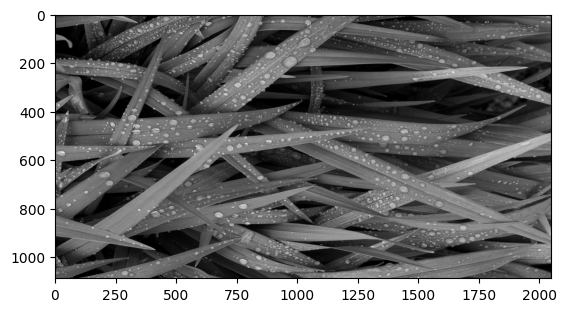

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [8]:
train_dataset[2]

In [26]:
import torch
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
writer = SummaryWriter()
# model = test()
model = FCN()
model = model.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
sign_function = SignFunction.apply
epochs = 5
z = 2e-3
path = 'models/'
criterion = nn.MSELoss()
valid_image = valid_dataset[0]
for epoch in range(epochs):
    for batch_idx, target in enumerate(trainloader):
        pred = model(target)
        amp = pred[0][0]
        pi = pred[0][1]
        pred = amp * torch.exp(1j*pi)
        # pred = sign_function(pred)
        sim = tt.simulate(pred, z)
        # sim = torch.sum(sim)
        loss = criterion(target, sim.abs()**2)
        # loss = criterion(target, pred)
        writer.add_scalar("Loss/train", loss, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        print(f'Epoch {epoch:4d}/{epochs} Batch {batch_idx + 1}/{len(trainloader)} Cost: {loss.item():.6f}')
    pred = model(valid_image)
    # pred = sign_function(pred)
    pred = pred[0] * torch.angle(1j*pred[1])
    sim = tt.simulate(pred, z)
    
    # sim = torch.sum(sim, dim=1)/5
    sim = sim.abs()**2
    valid_loss = criterion(valid_image, sim)
    psnr = get_psnr(valid_image, sim)
    writer.add_scalar("PSNR/train", psnr, epoch)
    print(f'------ valid : Epoch {epoch:4d}/{epochs} MSE : {valid_loss.item():.6f} PSNR : {psnr}')
    torch.save(model, path + 'resnet2.pt')
writer.close()

Epoch    0/5 Batch 1/640 Cost: 0.196417
Epoch    0/5 Batch 2/640 Cost: 0.436566
Epoch    0/5 Batch 3/640 Cost: 0.047171
Epoch    0/5 Batch 4/640 Cost: 0.176962
Epoch    0/5 Batch 5/640 Cost: 0.071405
Epoch    0/5 Batch 6/640 Cost: 0.092268
Epoch    0/5 Batch 7/640 Cost: 0.490440
Epoch    0/5 Batch 8/640 Cost: 0.180635
Epoch    0/5 Batch 9/640 Cost: 0.553649
Epoch    0/5 Batch 10/640 Cost: 0.440416
Epoch    0/5 Batch 11/640 Cost: 0.121619
Epoch    0/5 Batch 12/640 Cost: 0.334682
Epoch    0/5 Batch 13/640 Cost: 0.158229
Epoch    0/5 Batch 14/640 Cost: 0.090793
Epoch    0/5 Batch 15/640 Cost: 0.219410
Epoch    0/5 Batch 16/640 Cost: 0.261309
Epoch    0/5 Batch 17/640 Cost: 0.277499
Epoch    0/5 Batch 18/640 Cost: 0.142698
Epoch    0/5 Batch 19/640 Cost: 0.313038
Epoch    0/5 Batch 20/640 Cost: 0.053527
Epoch    0/5 Batch 21/640 Cost: 0.067888
Epoch    0/5 Batch 22/640 Cost: 0.083135
Epoch    0/5 Batch 23/640 Cost: 0.102352
Epoch    0/5 Batch 24/640 Cost: 0.053845
Epoch    0/5 Batch 25/640

In [34]:
model = FCN()

In [35]:
model = torch.load('models/resnet1.pt')
model.to('cuda')

FCN(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1

torch.Size([1, 1088, 2048])



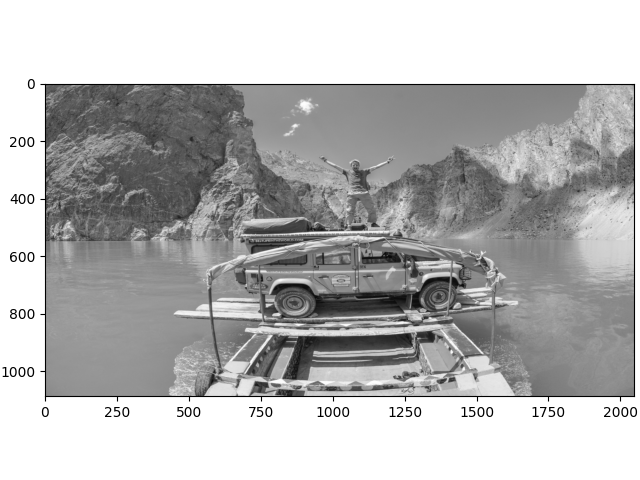

In [39]:
test = valid_dataset[50]
print(test.shape)
tt.show(test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



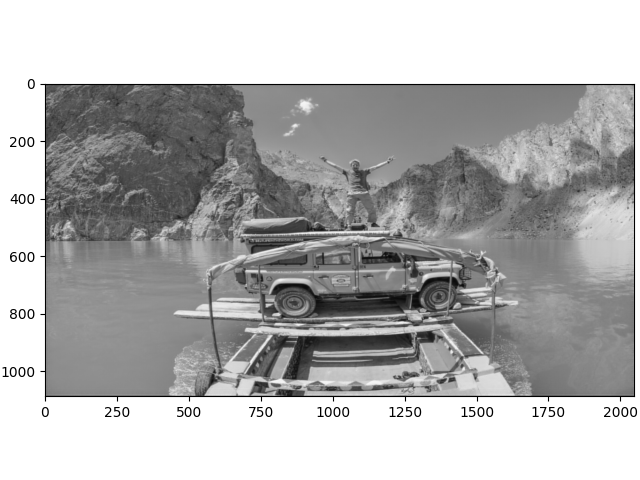

In [40]:
output = model(test)
# output.shape
complex = output[0] * torch.exp(1j*output[1])
sim = tt.simulate(complex, 2e-3).abs()**2
tt.show(sim)

In [41]:
get_psnr(sim, test)

26.918746948242188

In [24]:
output.shape

torch.Size([2, 1088, 2048])